In [170]:
import numpy as np
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
# from pint import tools as pt
path = 'C:/Users/perry/Desktop/Research/zurbuchen2023'

In [171]:
adata_raw = sc.read_h5ad('C:/Users/perry/Desktop/Research/zurbuchen2023/infection_cohort_adata_23-06-27.h5ad')

In [172]:
rbd_df = adata_raw.obs.copy()

In [173]:
rbd_df.columns

Index(['Row.names', 'orig.ident', 'nCount_RNA', 'nFeature_RNA',
       'nCount_Baiting', 'nFeature_Baiting', 'nCount_Protein',
       'nFeature_Protein', 'nCount_Hashing', 'nFeature_Hashing', 'percent.mt',
       'Hashing_maxID', 'Hashing_secondID', 'Hashing_margin',
       'Hashing_classification', 'Hashing_classification.global', 'hash.ID',
       'Timepoint', 'Patient', 'Vaccinated', 'time_after_vac', 'sample_group',
       'barcode', 'CTgene', 'CTnt', 'CTaa', 'CTstrict', 'Frequency',
       'cloneType', 'BCR.known', 'full.BCR.known', 'Isotype', 'cor_wt_Spike',
       'cor_B.1.351', 'cor_B.1.617.2', 'cor_RBD', 'bait.positive',
       'spike_RBD_positive', 'B.1.351_positive', 'B.1.617.2_positive',
       'all_positive', 'Dataset', 'RNA.weight', 'Protein.weight',
       'Full.Row.names', 'mu_count', 'mu_freq', 'c_call',
       'integratedRNA_nn_res.0.5', 'seurat_clusters',
       'integratedADT_nn_res.0.5', 'wsnn_res.0.4', 'named.clusters', 'ident'],
      dtype='object')

<Axes: xlabel='cor_RBD', ylabel='Count'>

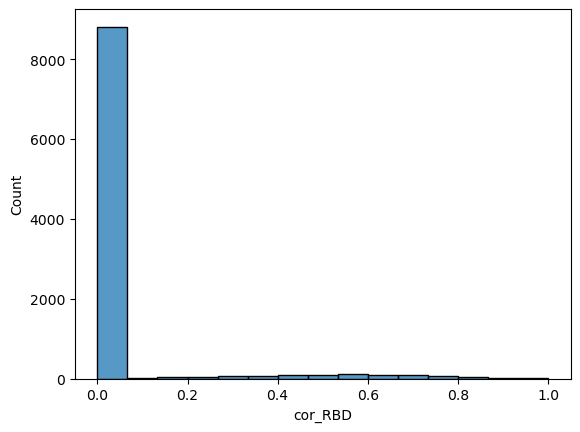

In [174]:
import seaborn as sns

sns.histplot(rbd_df['cor_RBD'])

In [175]:
rbd_df['Isotype'].value_counts()

IGHM       4269
IGHG       2954
unknown    1169
IGHA        977
IGHD        378
Name: Isotype, dtype: int64

In [176]:
rbd_df = rbd_df[rbd_df['ident'] != 'Unswitched']
rbd_df = rbd_df[rbd_df['ident'] != 'Atypical']
rbd_df = rbd_df[rbd_df['Isotype'] != 'IGHM']

In [177]:
rbd_df['BCR.known'].value_counts()

yes    4261
Name: BCR.known, dtype: int64

In [178]:
rbd_df['antigen_name'] = rbd_df[['cor_wt_Spike', 'cor_B.1.351', 'cor_B.1.617.2', 'cor_RBD']].apply(lambda x: x.idxmax(), axis=1)
rbd_df['max_corr'] = rbd_df[['cor_wt_Spike', 'cor_B.1.351', 'cor_B.1.617.2', 'cor_RBD']].apply(lambda x: x.max(), axis=1)

In [179]:
rbd_df = rbd_df[rbd_df['max_corr'] >= 0.5]
rbd_df.shape

(1154, 56)

In [180]:
rbd_df['antigen_name'].value_counts()

cor_RBD          347
cor_wt_Spike     320
cor_B.1.617.2    283
cor_B.1.351      204
Name: antigen_name, dtype: int64

In [181]:
# rbd_df[['cor_wt_Spike', 'cor_B.1.351', 'cor_B.1.617.2', 'cor_RBD', 'antigen_name', 'max_corr']]

In [182]:
file_path1 = 'C:/Users/perry/Desktop/Research/zurbuchen2023/Infection Cohort/'
file_path2 = '/outs/multi/vdj_b/all_contig_annotations.csv'

files = ['Set_1', 'Set_2', 'Set_3', 'Set_4']
chain_map = {'IGK':'LV', 'IGL':'LV', 'IGH':'HV'}

seq_dfs = {}

for file in files:
    df = pd.read_csv(file_path1 + file + file_path2, index_col=0)
    donor = file.split('_')[1]
    df.index = 'Dataset_' + str(donor) + '_' +  df.index
    df['Chain'] = df['chain'].map(chain_map)


    hchains = df[df['Chain'] == 'HV'][['fwr1', 'cdr1', 'fwr2', 'cdr2', 'fwr3', 'cdr3', 'fwr4']]
    lchains = df[df['Chain'] == 'LV'][['fwr1', 'cdr1', 'fwr2', 'cdr2', 'fwr3', 'cdr3', 'fwr4']]


    hchains.dropna(inplace=True)
    lchains.dropna(inplace=True)

    hchains['VH_AA'] = hchains.apply(lambda x: ''.join(x), axis=1)
    lchains['VL_AA'] = lchains.apply(lambda x: ''.join(x), axis=1)

    seqs = pd.merge(hchains, lchains, how = 'inner', left_index=True, right_index=True)[['VH_AA', 'VL_AA']]

    overlap_w_counts = np.intersect1d(seqs.index, rbd_df.index)

    seqs = seqs.loc[overlap_w_counts]
    
    seq_dfs[donor] = seqs

In [183]:
paired_seqs = pd.concat(seq_dfs)
paired_seqs.index = paired_seqs.index.droplevel(0)

paired_seqs = paired_seqs.loc[(np.intersect1d(paired_seqs.index, rbd_df.index))]
rbd_df = rbd_df.loc[(np.intersect1d(paired_seqs.index, rbd_df.index))] 

<Axes: xlabel='cor_wt_Spike', ylabel='Count'>

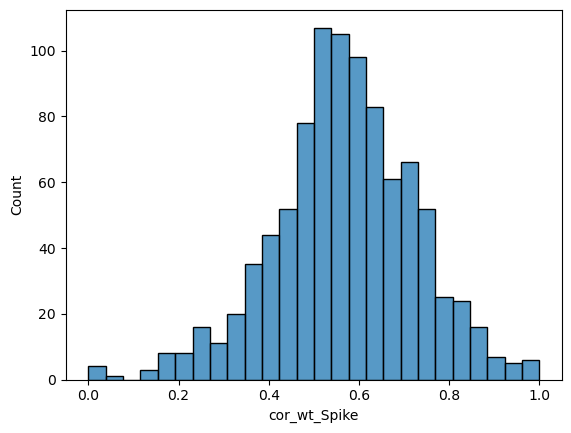

In [184]:
sns.histplot(rbd_df['cor_wt_Spike'])

In [185]:
assert len(rbd_df[rbd_df['bait.positive'] == 'no']) == 0

In [186]:
rbd_df['bait.positive'].value_counts()

yes    935
no       0
Name: bait.positive, dtype: int64

In [187]:
# rbd_binding = rbd_df[rbd_df['cor_RBD'] > 0.5].index

# # rbd_df[rbd_df['bait.positive'] == 'no']['cor_RBD'].max()
# rbd_neg = rbd_df[rbd_df['bait.positive'] == 'no'].index

In [188]:
# paired_seqs['Class'] = np.nan
# paired_seqs.loc[rbd_binding, 'Class'] = 1
# paired_seqs.loc[rbd_neg, 'Class'] = 0

# paired_seqs['Class'].value_counts()

In [189]:
paired_seqs['barcode'] = paired_seqs.index
# paired_seqs['cor_WT_spike'] = rbd_df['cor_wt_Spike']
paired_seqs[['cor_wt_Spike', 'cor_B.1.351', 'cor_B.1.617.2', 'cor_RBD']] = rbd_df[['cor_wt_Spike', 'cor_B.1.351', 'cor_B.1.617.2', 'cor_RBD']]
paired_seqs['Isotype'] = rbd_df['Isotype']
# paired_seqs = paired_seqs[~paired_seqs['cor_WT_spike'].isna()]


paired_seqs.index = np.array(range(len(paired_seqs))).astype(str)

In [190]:
paired_seqs.head()

,VH_AA,VL_AA,barcode,cor_wt_Spike,cor_B.1.351,cor_B.1.617.2,cor_RBD,Isotype
0,EVQLVESGGGLVQPGGSLRLSCEVSGLPFSTSWMSWVRQAPGKGLE...,SYVLTQPPSVSVAPGQTASITCGGNNIGSKTVHWYQQKPGQAPVLV...,Dataset_1_AAACCTGAGTGCGTGA-1,0.666601,0.414182,0.505411,0.000000,IGHG
1,QVQLVESGGGVVQPGRSLRLSCAASGFTFSSYGMHWVRQAPGKGLE...,SYELTQPLSVSVSPGQTASITCSGDKLSNKYASWYQQRPGQSPVLV...,Dataset_1_AAATGCCCATCTATGG-1,0.599866,0.400051,0.436166,0.000000,IGHG
2,QVQLQESGPGLVKPSETLSLTCAVSGGSVSSSRYYWSWLRQPPGKA...,EIVMTQSPATLSVSPGERATLSCGASQSVGTKLAWYQQKPGQAPRL...,Dataset_1_AACTCAGCATTGCGGC-1,0.421502,0.510165,0.000000,0.000000,IGHG
3,QVQLVQSGADVKKPGASVTVSCKASGYTFTNYYIHWVRQAPGQRLE...,EIVLTQSPGTLSLSPGERATLSCRASQSFSISYLAWYQQKPGQAPR...,Dataset_1_AACTCCCAGCGAAGGG-1,0.786032,0.481569,0.714887,0.992167,IGHA
4,QVQLVQSGADVKKPGASVTVSCKASGYTFTNYYIHWVRQAPGQRLE...,DIQMTQSPSSLSASVGDRANITCRASQSISNYLNWYQQKPGKAPKL...,Dataset_1_AACTCCCAGCGAAGGG-1,0.786032,0.481569,0.714887,0.992167,IGHA


In [191]:
## Seqs from CoVAbDab notebook

### Spike B.1.351 (beta) https://www.rcsb.org/structure/7LYQ
b1351 = 'MFVFLVLLPLVSSQCVNFTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFANPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRGLPQGFSALEPLVDLPIGINITRFQTLLALHISYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGNIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVKGFNCYFPLQSYGFQPTYGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQGVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPGSASSVASQSIIAYTMSLGVENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQGSGYIPEAPRDGQAYVRKDGEWVLLSTFLGRSLEVLFQ'

### Spike B.1.617.2 (delta) https://www.rcsb.org/structure/7tov
b16172 = 'MFVFLVLLPLVSSQCVNLRTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLDVYYHKNNKSWMESGVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYRYRLFRKSNLKPFERDISTEIYQAGSKPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQGVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSRGSASSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQNVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQGSGYIPEAPRDGQAYVRKDGEWVLLSTFLGRSLEVLFQGP'

### SARS-2_WT RBD
# https://www.rcsb.org/structure/6m0j
wt_rbd = 'RVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNF'

### SARS-2_WT RBD
# https://www.uniprot.org/uniprotkb/P0DTC2/entry#sequences
wt_spike = 'MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIVMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT'


antigen_dict = {'wt_Spike':wt_spike, 'B.1.351':b1351, 'B.1.617.2':b16172, 'RBD':wt_rbd}

In [192]:
paired_seqs['antigen_name'] = paired_seqs[['cor_wt_Spike', 'cor_B.1.351', 'cor_B.1.617.2', 'cor_RBD']].apply(lambda x: str(x.idxmax()).replace('cor_', ''), axis=1)
paired_seqs['antigen_seq'] = paired_seqs['antigen_name'].map(antigen_dict)
paired_seqs.index = 'Zurbuchen:' + paired_seqs['antigen_name'] + ':' + paired_seqs.index

In [193]:
paired_seqs['antigen_seq'].value_counts()

RVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNF                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [195]:
paired_seqs.to_csv('zurbuchen_binders_v2_24-03-08.csv')